# Телекоммуникации

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

**contract_new.csv** — информация о договоре;  
**personal_new.csv** — персональные данные клиента;  
**internet_new.csv** — информация об интернет-услугах;  
**phone_new.csv** — информация об услугах телефонии.  

**Файл contract_new.csv**

customerID — идентификатор абонента;  
BeginDate — дата начала действия договора;  
EndDate — дата окончания действия договора;  
Type — тип оплаты: раз в год-два или ежемесячно;  
PaperlessBilling — электронный расчётный лист;  
PaymentMethod — тип платежа;  
MonthlyCharges — расходы за месяц;  
TotalCharges — общие расходы абонента.  

**Файл personal_new.csv**

customerID — идентификатор пользователя;  
gender — пол;  
SeniorCitizen — является ли абонент пенсионером;  
Partner — есть ли у абонента супруг или супруга;  
Dependents — есть ли у абонента дети.  

**Файл internet_new.csv**

customerID — идентификатор пользователя;  
InternetService — тип подключения;  
OnlineSecurity — блокировка опасных сайтов;  
OnlineBackup — облачное хранилище файлов для резервного копирования данных;  
DeviceProtection — антивирус;  
TechSupport — выделенная линия технической поддержки;  
StreamingTV — стриминговое телевидение;  
StreamingMovies — каталог фильмов. 

**Файл phone_new.csv**

customerID — идентификатор пользователя;  
MultipleLines — подключение телефона к нескольким линиям одновременно.  

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

**План работы:**
Провести исследовательский анализ данных.
Произвести предобработку (удалить дубликаты, устранить аномалии и выбросы, заполнить пропуски).
Произвести подготовку данных к обучению - создать новые признаки, удалить ненужные или коррелирующие признаки.
Обучить модели с подбором гиперпараметров: логистическую регрессию, модели градиентного бустинга: xgboost, ccatboost, lightgbm на тренировочных данных.
Выбрать наилучшую модель по метрике roc-auc на тренировочных данных.
Проверить качество модели с подобранными гиперпараметрами на тестовых данных и посмотреть на матрицу ошибок.
Произвести подбор порога классификации.
Исследовать вклад признаков в предсказания модели.

## Загрузка данных

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install xgboost
!pip install lightgbm
!pip install phik
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve,\
    classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from phik import phik_matrix
from sklearn.pipeline import Pipeline

import shap

RANDOM_STATE = 201123

In [4]:
contract = pd.read_csv('contract_new.csv', parse_dates=[1, 2])
internet = pd.read_csv('internet_new.csv')
personal = pd.read_csv('personal_new.csv')
phone = pd.read_csv('phone_new.csv')

Посмотрим на таблицы

In [5]:
def get_info(data):
    print(f'Кол-во явных дубликатов: {data.duplicated().sum()}\n')
    display(data.info())
    display(data.sample(4))

In [6]:
get_info(personal)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
1448,2958-NHPPS,Male,0,No,No
1813,0817-HSUSE,Male,0,No,No
1943,7442-YGZFK,Male,0,No,No
5718,9840-DVNDC,Male,0,No,No


In [7]:
get_info(contract)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4052,9667-EQRXU,2017-06-01,2019-07-01,Month-to-month,Yes,Electronic check,40.30,1007.5
5396,5627-TVBPP,2017-03-01,No,One year,Yes,Credit card (automatic),20.10,703.5
2408,6619-RPLQZ,2016-05-01,No,Two year,No,Mailed check,20.85,938.25
1332,4656-CAURT,2014-05-01,No,Two year,No,Bank transfer (automatic),23.95,1652.55


In [8]:
get_info(internet)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4699,2887-JPYLU,DSL,No,No,No,No,No,No
1912,2450-ZKEED,DSL,No,No,Yes,Yes,No,No
4745,8364-TRMMK,DSL,No,No,No,No,No,No
4357,8023-QHAIO,Fiber optic,No,No,No,Yes,No,No


In [9]:
get_info(phone)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
1733,5777-ZPQNC,No
1400,5071-FBJFS,No
1555,4854-CIDCF,No
4869,2786-GCDPI,Yes


Всего мы наблюдаем 7043 клиента.
Почти у всех типы данных указаны вено, кроме признака EndDate, TotalCharges и у SeniorCitizen - это категориальный признак и лучше, если он будет типа str.

В таблице phone и internet меньше данных, это значит что скорее всего не все клиенты из 7043 человек подключили данные услуги.

Данные разделены на 4 таблицы, необходимо их соединить в один датафрейм перед более глубоким анализом и для полного понимания данных.

## Объединение данных

In [10]:
result = pd.merge(personal, contract, on='customerID', how='outer')
result2 = pd.merge(result, internet, on='customerID', how='outer')
df = pd.merge(result2, phone, on='customerID', how='outer')

## Исследовательский анализ и предобработка данных объединённого датафрейма

Посмотрим вглубь нового датафрейма

In [11]:
get_info(df)

Кол-во явных дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           7043 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 

None

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
4617,3007-FDPEA,Female,0,No,No,2019-12-01,No,Month-to-month,Yes,Bank transfer (automatic),20.70,41.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
6974,0422-UXFAP,Female,0,Yes,No,2015-11-01,No,One year,Yes,Electronic check,98.85,5041.35,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
2437,0567-GGCAC,Female,0,No,No,2019-07-01,No,Month-to-month,No,Electronic check,61.40,429.8,DSL,Yes,Yes,Yes,No,No,No,No
3938,6629-LADHQ,Female,0,No,No,2019-12-01,No,Month-to-month,No,Mailed check,50.95,105.98,DSL,Yes,No,No,No,No,No,No


Что сразу бросается в глаза - это наименования столбцов. Для удобной работы переведем их в snake_case

In [12]:
df.columns = df.columns.str.lower()
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'begindate', 'enddate', 'type', 'paperlessbilling', 'paymentmethod',
       'monthlycharges', 'totalcharges', 'internetservice', 'onlinesecurity',
       'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv',
       'streamingmovies', 'multiplelines'],
      dtype='object')

In [13]:
df = df.rename(columns={
    'customerid': 'customer_id',
    'seniorcitizen': 'senior_citizen',
    'begindate': 'begin_date',
    'enddate': 'end_date',
    'paperlessbilling': 'paper_less_billing',
    'paymentmethod': 'payment_method',
    'monthlycharges': 'monthly_charges',
    'totalcharges': 'total_charges',
    'internetservice': 'internet_service',
    'onlinesecurity': 'online_security',
    'onlinebackup': 'online_backup',
    'deviceprotection': 'device_protection',
    'techsupport': 'tech_support',
    'streamingtv': 'streaming_tv',
    'streamingmovies': 'streaming_movies',
    'multiplelines': 'multiple_lines',
})
df.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'begin_date', 'end_date', 'type', 'paper_less_billing',
       'payment_method', 'monthly_charges', 'total_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

Явных дубликатов в таблице нет. Проверим на дубликаты в поле customer_id

In [14]:
df['customer_id'].duplicated().sum()

0

Данные об общих тратах - это данные типа float, но сейчас это тип object. Вероятно часть данных записано не цифрами, а иными знаками. Приведем к числовому типу с заменой на Nan.

In [15]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   gender              7043 non-null   object        
 2   senior_citizen      7043 non-null   int64         
 3   partner             7043 non-null   object        
 4   dependents          7043 non-null   object        
 5   begin_date          7043 non-null   datetime64[ns]
 6   end_date            7043 non-null   object        
 7   type                7043 non-null   object        
 8   paper_less_billing  7043 non-null   object        
 9   payment_method      7043 non-null   object        
 10  monthly_charges     7043 non-null   float64       
 11  total_charges       7032 non-null   float64       
 12  internet_service    5517 non-null   object        
 13  online_security     5517 non-null   object      

Изменим тип данных для senior_citizen и end_date

In [16]:
df['senior_citizen'] = df['senior_citizen'].astype(str)
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')
df.dtypes

customer_id                   object
gender                        object
senior_citizen                object
partner                       object
dependents                    object
begin_date            datetime64[ns]
end_date              datetime64[ns]
type                          object
paper_less_billing            object
payment_method                object
monthly_charges              float64
total_charges                float64
internet_service              object
online_security               object
online_backup                 object
device_protection             object
tech_support                  object
streaming_tv                  object
streaming_movies              object
multiple_lines                object
dtype: object

Посмотрим, как распределены имеющиеся у нас количественные признаки. Для начала рассмотрим даты.

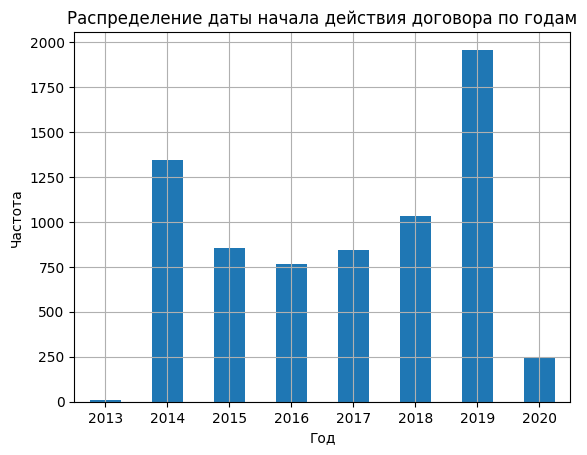

In [17]:
df['begin_date'].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Год')
plt.ylabel('Частота')
plt.title('Распределение даты начала действия договора по годам')
plt.xticks(rotation=360)
plt.grid()
plt.show()

Виден спад подключений с 2014 года по 2016, далее - рост числа подключившихся.
Больше всего подключившихся в 2019 году. Возможно это связано с крупной рекламной компанией или акционными предложениями. Возможно среди этих клиентов на данный момент времени есть меньше расторгнувших договор, чем среди ранее подключенных абонентов.

Рассмотрим подключение по месяцам без использования 2020 года, так как данные за этот год неполные

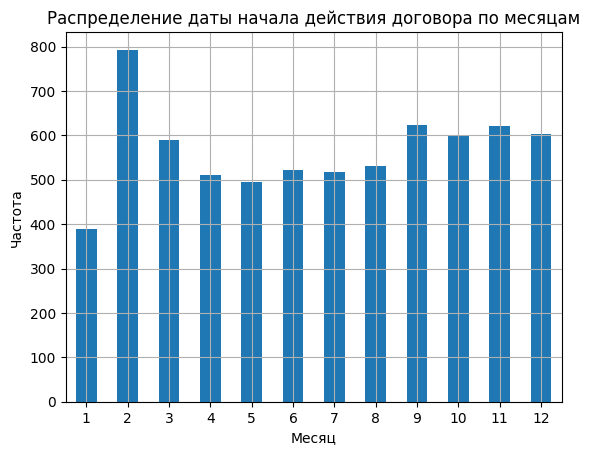

In [18]:
df[df['begin_date']<'2020']['begin_date'].dt.month.value_counts().sort_index().plot.bar()
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.title('Распределение даты начала действия договора по месяцам')
plt.xticks(rotation=360)
plt.grid()
plt.show()

Если смотреть информацию по месяцам - заметно, что в фервале люди заключают договора чуть чаще чем в остальные месяцы. Реже всего -  в январе. Летом - с мая по август меньше, чем осенью-зимой.

Рассмотрим разбиение окончания договора по годам и месяцам.

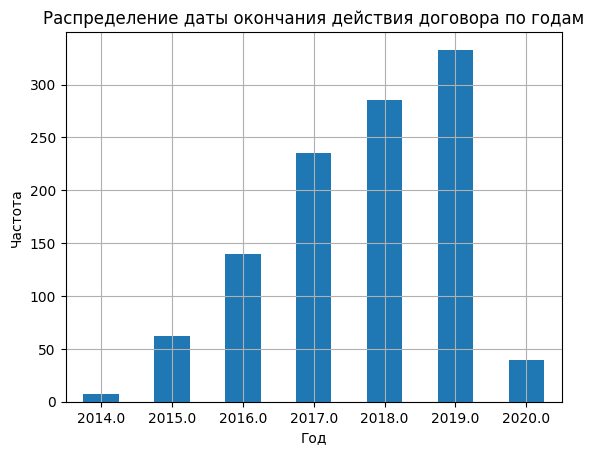

In [19]:
df['end_date'].dt.year.value_counts().sort_index().plot.bar()
plt.xlabel('Год')
plt.ylabel('Частота')
plt.title('Распределение даты окончания действия договора по годам')
plt.xticks(rotation=360)
plt.grid()
plt.show()

Распределение окончания действия договора имеет линейный тренд. Т.е наблюдается прирост прекращения пользования услугами. С 2015 по 2016 год он больше, чем с 2017 по 2019.
 Соответственно процент отписок относительно общего числа абонентов растет.

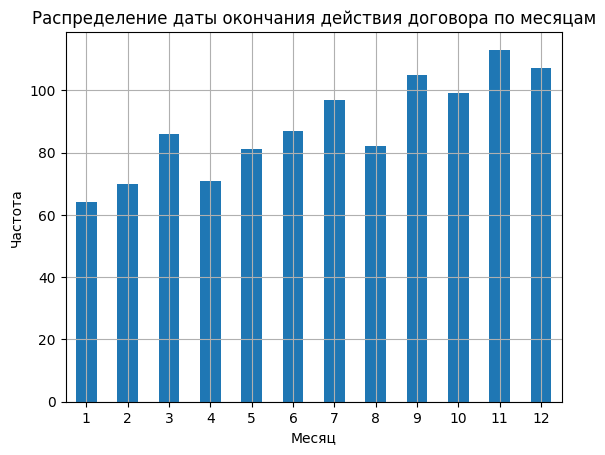

In [20]:
df[df['end_date']<'2020']['end_date'].dt.month.value_counts().sort_index().plot.bar()
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.title('Распределение даты окончания действия договора по месяцам')
plt.xticks(rotation=360)
plt.grid()
plt.show()

Чаще всего люди прекращают пользоваться договором с сентября по декабрь. Реже - в январе, феврале и апреле.

Создадим функцию для построения графиков для вещественных признаков, не являюшимися датами.

In [21]:
def get_num_plots(df, column):
    plt.figure(figsize=(11, 3))
    plt.suptitle(f'Графики распределения признака {column}')

    plt.subplot(1, 2, 1)
    plt.grid()
    sns.histplot(df[column], color='orange')

    plt.subplot(1, 2, 2)
    plt.grid()
    sns.boxplot(x=df[column], color='orange')

    display(df[column].describe())

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

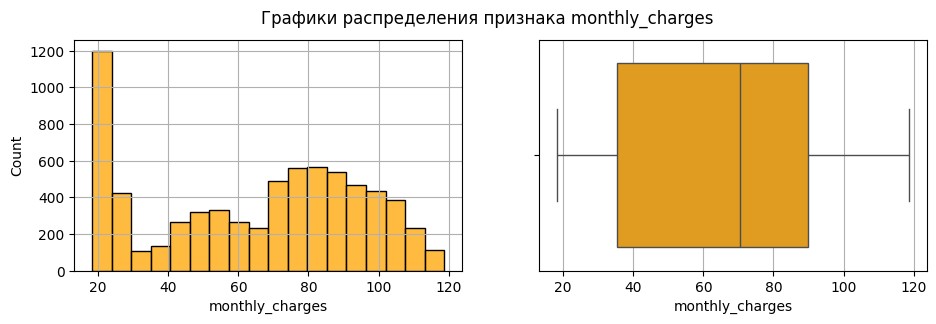

In [22]:
get_num_plots(df, 'monthly_charges')

Можно выделить, что 25% людей платит в месяц менее 35 y.e, остальная часть в месяц отдает от 35 до 120 y.e в месяц.
Средняя сумма расходов клиента в месяц 70 y.e. Аномалий и выбросов нет.

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: total_charges, dtype: float64

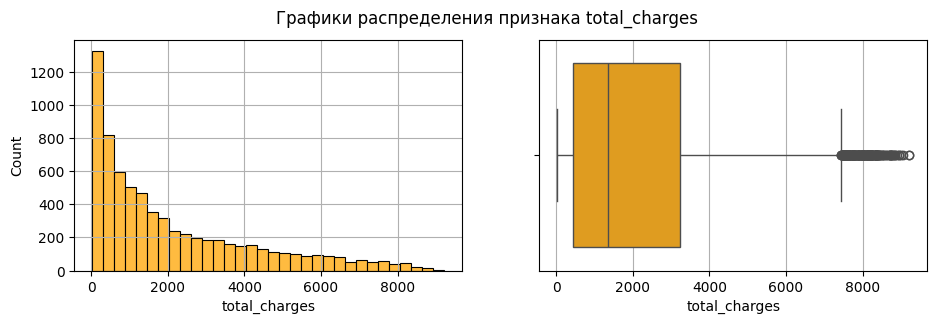

In [23]:
get_num_plots(df, 'total_charges')

50% клиентов заплатила менее 1345 y.e к моменту выгрузки данных. Оставшаяся часть - от 1345 и до 9200. Выделяется большое кол-во абонементов, заплативших менее 300 y.e. Это может быть связано с небольшой продолжительность пользования услугами из-за недавнего начала или быстрого прекращения, а также с небольшой средней платой в месяц.

Рассмотрим распределение категориальных признаков, в которых нет пропусков.

In [24]:
def get_countplot(df, column):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x=column, palette="viridis")
    plt.title(f'Распределение {column}')
    plt.xticks(rotation=30)
    plt.grid()
    plt.show()

In [25]:
columns_non_null = ['gender', 'senior_citizen', 'partner', 'dependents',
                    'type', 'paper_less_billing',
                    'payment_method']

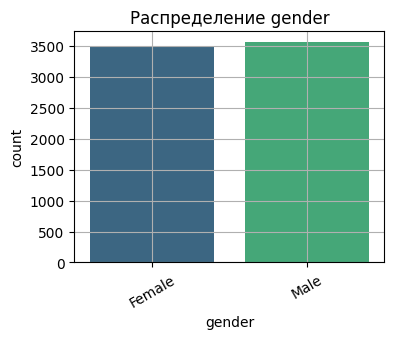

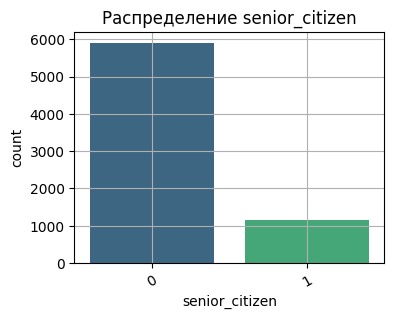

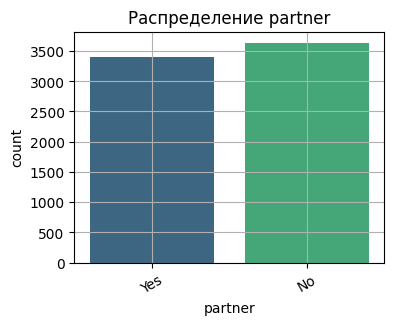

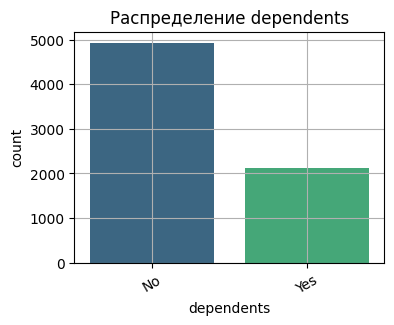

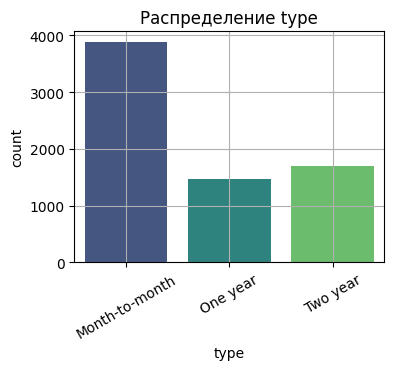

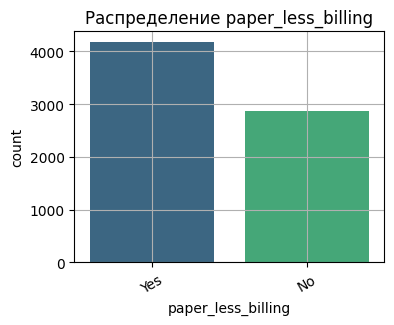

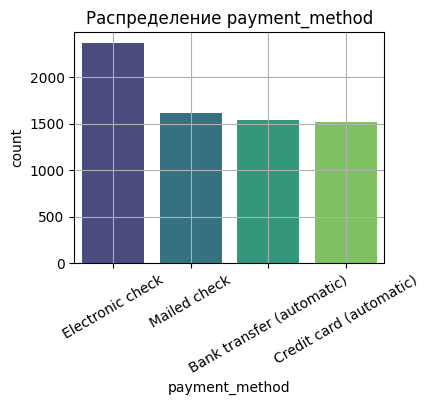

In [26]:
for column in columns_non_null:
    get_countplot(df, column)

Признак gender распределен поровну.
Среди абонентов большая часть - не пожилые.
Чуть больше половины абонентов не состоят в браке
У 30% абонентов есть дети.
Большая часть абонентов выбрали подписку по месяцам, около 1300 человек выбрали оплату за год и около 1500 - за 2 года. Возможно выбор зависит от наличия детей/супругов.
Более половины абонентов имеют электронный расчетный лист.
Самый популярный метод оплаты - электронный чек (около 35%). Среди остальных - поровну распределены почтовый чек, автоматическая оплата банковской картой и автоматическая оплата кредитной картой.

Для того чтобы модель могла предсказывать, уйдет абонент или нет, необходимо отделить целевой признак.
В нашем случае информацию о том, разорвал ли клиент договор или нет говорит признак end_date - дата окончания договора.
Необходимо создать целевой признак - target, на базе end_date: если у абонемента стоит дата окончания договора - значит он ушел (1), а если нет, то он продолжает быть клиентом (0).

In [27]:
df['target'] = np.where(pd.notna(df['end_date']), 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   gender              7043 non-null   object        
 2   senior_citizen      7043 non-null   object        
 3   partner             7043 non-null   object        
 4   dependents          7043 non-null   object        
 5   begin_date          7043 non-null   datetime64[ns]
 6   end_date            1101 non-null   datetime64[ns]
 7   type                7043 non-null   object        
 8   paper_less_billing  7043 non-null   object        
 9   payment_method      7043 non-null   object        
 10  monthly_charges     7043 non-null   float64       
 11  total_charges       7032 non-null   float64       
 12  internet_service    5517 non-null   object        
 13  online_security     5517 non-null   object      

Создадим новый признак - продолжительность сотрудничества, то есть сколько дней человек пользуется услугами компании. Для этого заменим пропуски в end_date на дату выгрузки данных (1 февраля 2020 года), и вычтем из end_date значения begin_date

In [28]:
df['end_date'] = df['end_date'].fillna('2020-02-01')

In [29]:
df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   gender              7043 non-null   object        
 2   senior_citizen      7043 non-null   object        
 3   partner             7043 non-null   object        
 4   dependents          7043 non-null   object        
 5   begin_date          7043 non-null   datetime64[ns]
 6   end_date            7043 non-null   datetime64[ns]
 7   type                7043 non-null   object        
 8   paper_less_billing  7043 non-null   object        
 9   payment_method      7043 non-null   object        
 10  monthly_charges     7043 non-null   float64       
 11  total_charges       7032 non-null   float64       
 12  internet_service    5517 non-null   object        
 13  online_security     5517 non-null   object      

In [31]:
df['contract_duration_days'] = (df['end_date'] - df['begin_date']).dt.days
df.head(4)

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paper_less_billing,payment_method,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration_days
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,NaN,0,31
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,Male,0,No,No,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371


Удалим столбцы с датами, так как они нам более не нужны, а так же удалим столбец customer_id с уникальными идентификаторами пользователей

In [32]:
df = df.drop(columns=['begin_date', 'end_date', 'customer_id'])
df.head(4)

,gender,senior_citizen,partner,dependents,type,paper_less_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,target,contract_duration_days
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,NaN,0,31
1,Male,0,No,No,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,0,123
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,NaN,0,1371


Разберемся с пропусками.
Обнаружены пропуски в total_charges. Заменим их нулями

In [33]:
df['total_charges'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  7043 non-null   object 
 1   senior_citizen          7043 non-null   object 
 2   partner                 7043 non-null   object 
 3   dependents              7043 non-null   object 
 4   type                    7043 non-null   object 
 5   paper_less_billing      7043 non-null   object 
 6   payment_method          7043 non-null   object 
 7   monthly_charges         7043 non-null   float64
 8   total_charges           7043 non-null   float64
 9   internet_service        5517 non-null   object 
 10  online_security         5517 non-null   object 
 11  online_backup           5517 non-null   object 
 12  device_protection       5517 non-null   object 
 13  tech_support            5517 non-null   object 
 14  streaming_tv            5517 non-null   

Все остальные пропуски обнаружены там, где в таблицах phone и internet у клиента не было данных. Это значит, что клиент не подключал данные услуги и мы можем заменить пропуски на значение 'No'.

In [34]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  7043 non-null   object 
 1   senior_citizen          7043 non-null   object 
 2   partner                 7043 non-null   object 
 3   dependents              7043 non-null   object 
 4   type                    7043 non-null   object 
 5   paper_less_billing      7043 non-null   object 
 6   payment_method          7043 non-null   object 
 7   monthly_charges         7043 non-null   float64
 8   total_charges           7043 non-null   float64
 9   internet_service        7043 non-null   object 
 10  online_security         7043 non-null   object 
 11  online_backup           7043 non-null   object 
 12  device_protection       7043 non-null   object 
 13  tech_support            7043 non-null   object 
 14  streaming_tv            7043 non-null   

Пропуски устранены. Посмотрим на данные еще раз и на распределение признаков.

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: contract_duration_days, dtype: float64

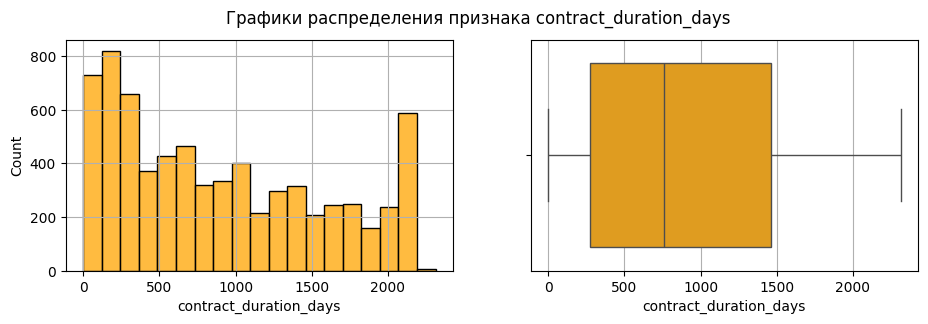

In [35]:
get_num_plots(df, 'contract_duration_days')

 Средняя продолжительность контракта - 900 дней. Но без разреза по целевому признаку сложно уловить нюансы. Посмотрим на распределение продолжитеьности контракта для тех, кто разорвал контракт.

count    1101.000000
mean      924.863760
std       458.771309
min        28.000000
25%       577.000000
50%       915.000000
75%      1249.000000
max      2129.000000
Name: contract_duration_days, dtype: float64

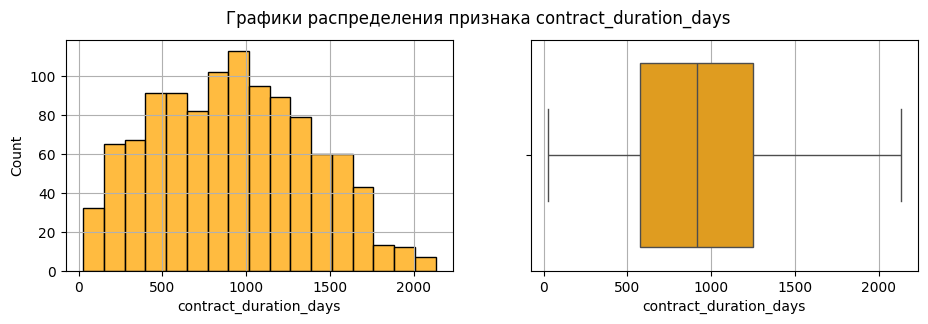

In [36]:
get_num_plots(df[df['target'] == 1], 'contract_duration_days')

Распределение продолжительности контракта близко к нормальному. Средняя продолжительность - 925 дней, а медианная 915 дней. 75% человек выплатили 1250 y.e

Посмотрим на распределение продолжитеьности контракта для тех, кто не перестал пользоваться услугами.

count    5942.000000
mean      893.681084
std       716.958551
min         0.000000
25%       245.000000
50%       702.000000
75%      1523.000000
max      2314.000000
Name: contract_duration_days, dtype: float64

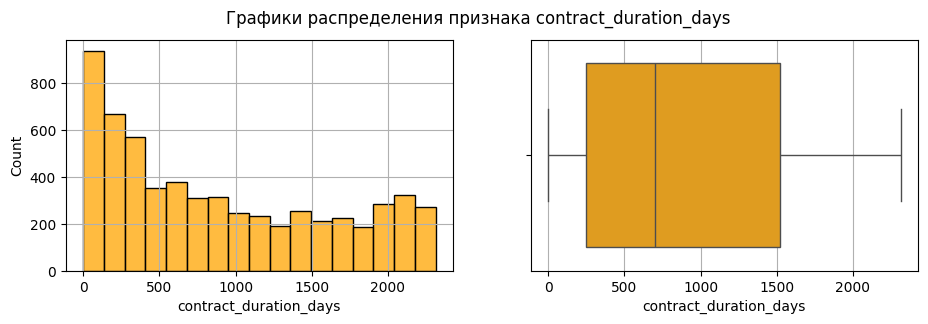

In [37]:
get_num_plots(df[df['target'] == 0], 'contract_duration_days')

Среди действующих абонентов средняя продолжительность контракта меньше - 890 дня, а медианная 700 дней. Т.е распределение смещено в стону непродолжительный договоров. Это может быть связано с тем, что много новых клиентов пришло в 2019.

Рассмотрим распределение для каждого признака в разрезе целевого признака

In [38]:
def get_countplot(df, column):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x=column, hue='target', palette="viridis")
    plt.title(f'Распределение {column}')
    plt.xticks(rotation=30)
    plt.show()


columns = ['gender', 'senior_citizen', 'partner', 'dependents',
           'type', 'paper_less_billing',
           'payment_method',
           'internet_service', 'online_security', 'online_backup',
           'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
           'multiple_lines']

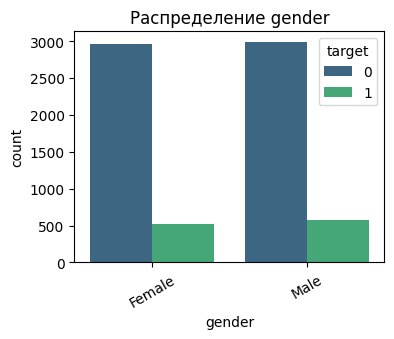

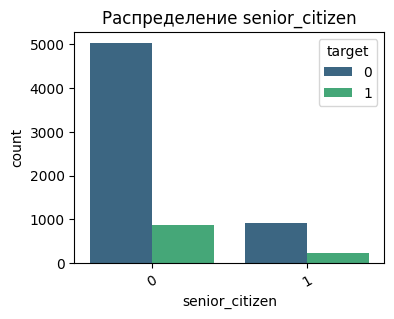

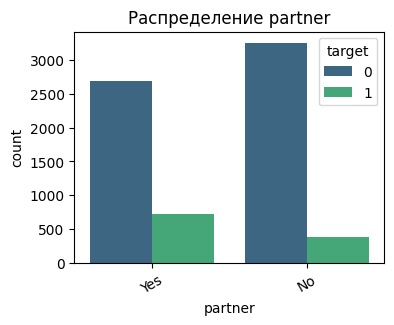

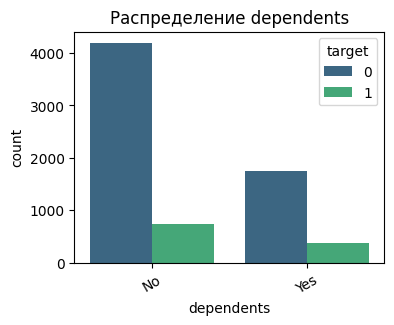

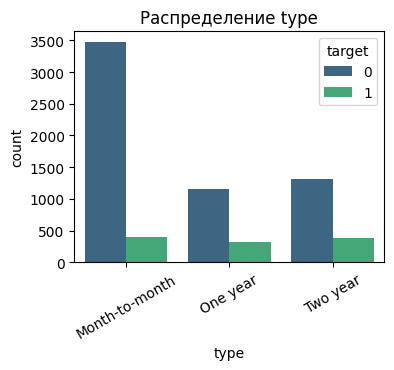

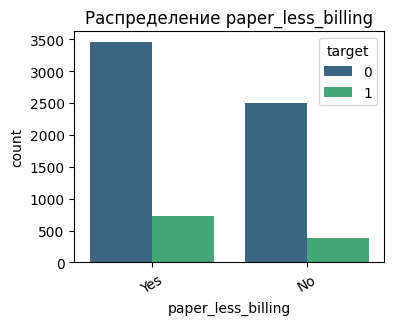

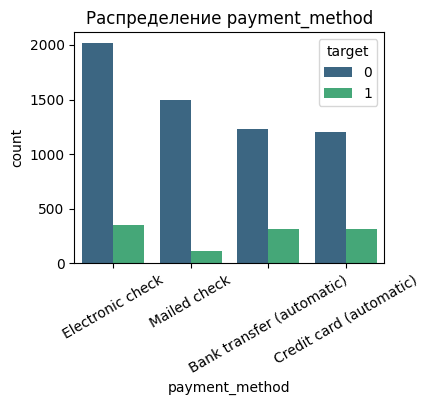

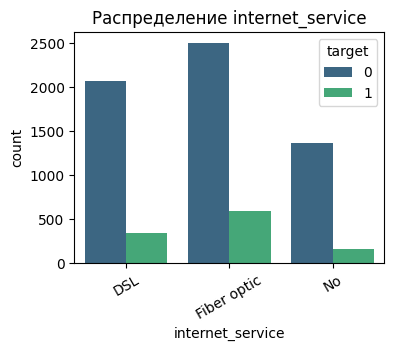

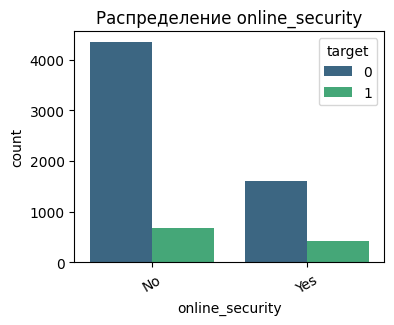

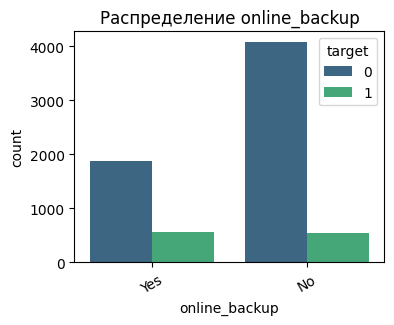

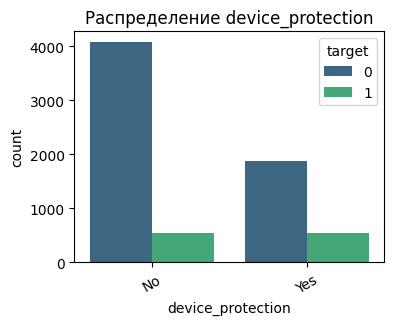

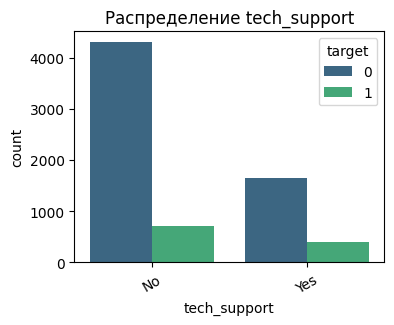

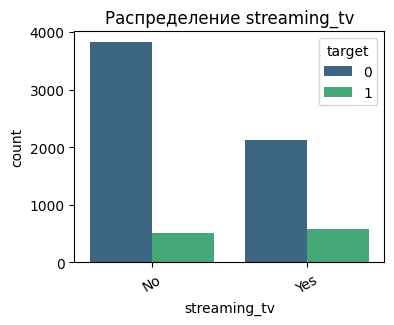

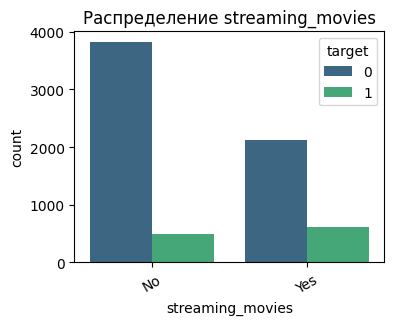

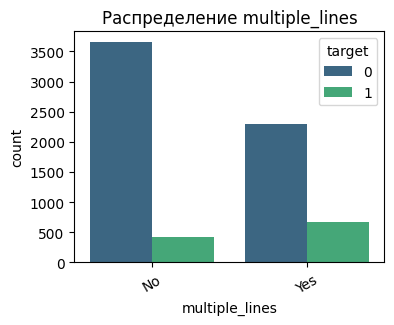

In [39]:
for column in columns:
    get_countplot(df, column)

Процент ушедших и кол-во оставшихся и ушедших человек среди мужчин и среди женщин одинаковое, значит, что этот признак не информативен для предсказаний и его можно убрать.  
Среди пожилых людей больший процент людей прекратили пользоваться услугами.  
Люди в браке чаще заканчивают договор, чем люди не в браке.  
Среди ушедших больше тех, кто не имеет детей.  
Те, кто прекратил сотрудничество практически равновероятно имеют любой тип оплаты.  
Среди ушедших больше тех, кто не имеет электронный расчетный лист.  
Среди ушедших меньше всего тех, у кого метод оплаты - почтовый чек.  
Наиболее популярный тип подключения интернета как среди ушедших так и у действующих - оптоволокно.  
Среди ушедших поровну подключивших услугу облачное хранилище файлов для резервного копирования данных, вероятно этот признак не информативен для предсказания.
Как видим по графикам, распределения признаков streaming_tv, streaming_movies, tech_support, device_protection ведут себя похожим образом.  

Проведем корреляционный анализ для выявления наиболее слабых признаков

Построим хитмап признаков корреляции для всего датасета

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'target', 'contract_duration_days']


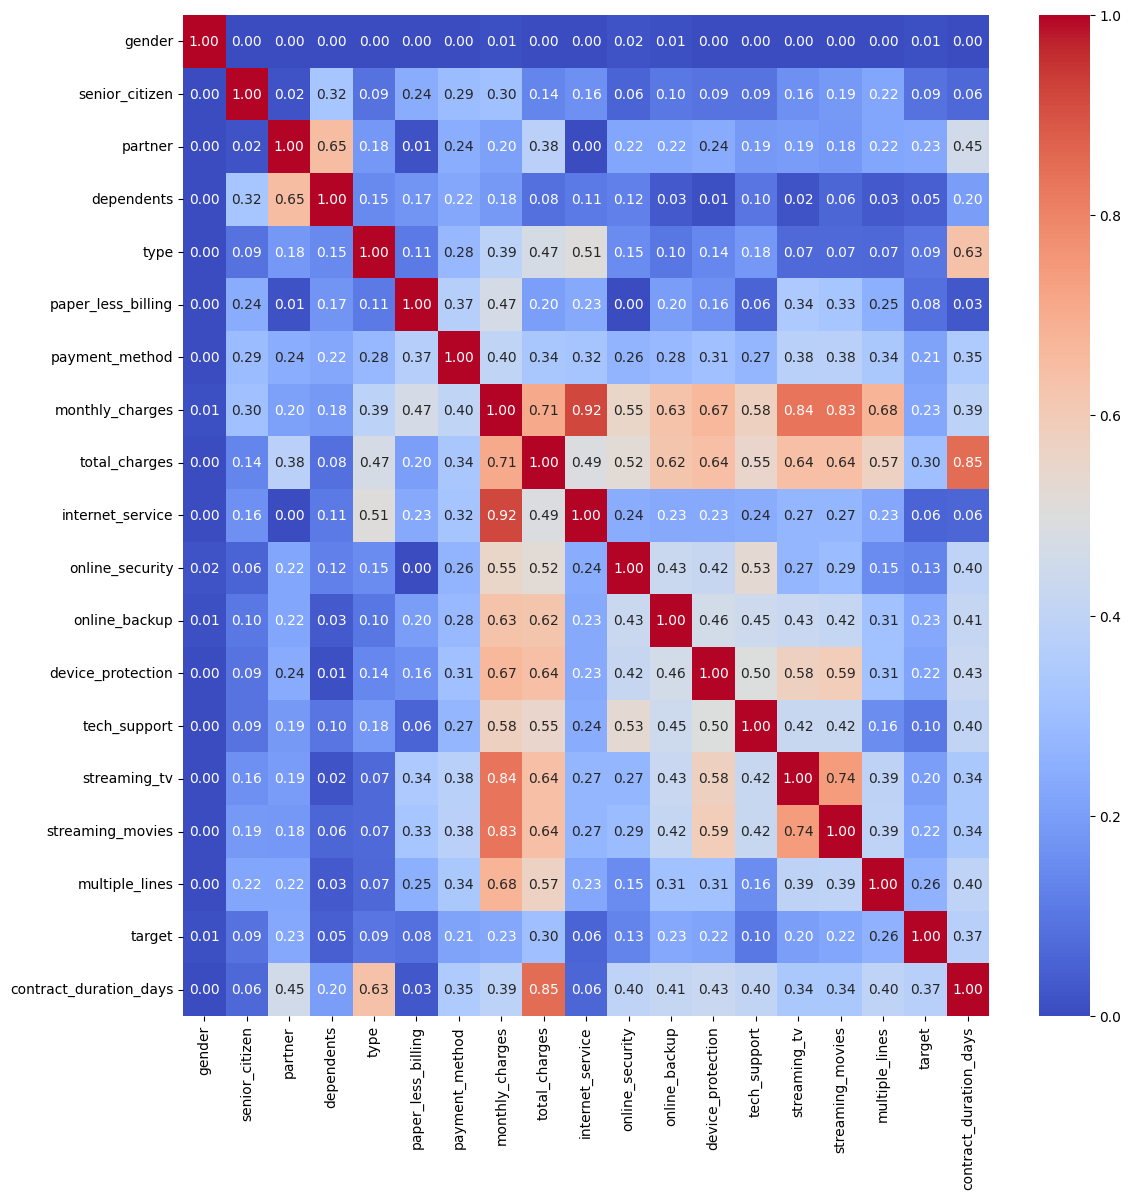

In [40]:
plt.figure(figsize=(13, 13))
sns.heatmap(phik_matrix(df), cmap='coolwarm', annot=True, fmt=".2f");
plt.show()

Можем наблюдать следующее:  
Как и предполагалось, гендер совсем не коррелирует с таргетом и с остальными признаками. Его можно убрать.  
Кол-во детей немного коррелирует с состоянием в браке.  
Тип оплаты немного коррелирует с продолжительностью контракта. Это может быть связано, так как если человек выбрал оплату ежегодно или раз в 2 года, то он и дольше воспользуется услугой.  
Подключение услуги стримминговое тв сильно коррелирует с услугой подключения фильмов. Если присмотреться, тв и фильмы одинаково коррелируют с остальными признаками. Один из них удалим.


Помесячная плата сильно коррелирует с internet_service, streaming_tv и streaming_movies. А также немного коррелирует с остальными интернет-услугами.  
Общие расходы абонента сильно коррелируют с продолжительностью контракта в днях. Это может быть связано с тем, что чем больше продолжительность, тем больше человек оплатил товар.  
Если присмотреться, то можно заметить корреляцию между тремя признаками: общие расходы, расходы в месяц и кол-во дней контракта. Если поделить общие расходы на расходы в месяц — получится продолжительность контракта в месяцах, которая будет высоко коррелировать с продолжительностью контракта в днях. Это и то, что оба признака суммы трат высоко коррелируют с другими признаками, позволяют нам убрать их из датасета.

Удалим неважные признаки.

In [41]:
df = df.drop(columns=['gender',
                      'monthly_charges',
                      'total_charges',
                      'streaming_tv',
                      'dependents',
                     ])

##  Подготовка данных

Необходимо разбить данные на тренировочные и тестовые, а также отделить фичи от целевого признака.

In [42]:
train, test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)
print(f'train = {train.shape}, \ntest  = {test.shape}.')

train = (5282, 14), 
test  = (1761, 14).


In [43]:
train_features = train.drop(['target'], axis=1)
train_target = train['target']
test_features = test.drop(['target'], axis=1)
test_target = test['target']
print(f'train_features = {train_features.shape}, \ntest_features  = {test_features.shape}.')

train_features = (5282, 13), 
test_features  = (1761, 13).


Выделим категориальные и количественные признаки для дальнейшей обработки перед обучением модели

In [44]:
cat_features = train_features.select_dtypes(include=['object']).columns
num_features = train_features.select_dtypes(exclude='object').columns

In [45]:
cat_features, num_features

(Index(['senior_citizen', 'partner', 'type', 'paper_less_billing',
        'payment_method', 'internet_service', 'online_security',
        'online_backup', 'device_protection', 'tech_support',
        'streaming_movies', 'multiple_lines'],
       dtype='object'),
 Index(['contract_duration_days'], dtype='object'))

## Обучение моделей машинного обучения


Построим пайплайн для LogisticRegression

In [46]:
column_transformer_logreg = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(include_bias=True))
    ]), num_features)])

pipeline_logreg = Pipeline([
    ('preprocess', column_transformer_logreg),
    ('logreg', LogisticRegression(random_state=RANDOM_STATE))
])
param_grid_logreg = [
    {
        'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
        'logreg__solver': ['liblinear'],
        'logreg__penalty': ['l1', 'l2'],
        'logreg__class_weight': ['balanced', None]
    },
    {
        'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
        'logreg__solver': ['lbfgs', 'sag'],
        'logreg__penalty': ['l2', None],
        'logreg__class_weight': ['balanced', None]
    },
    {
        'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
        'logreg__solver': ['saga'],
        'logreg__penalty': ['elasticnet', 'l1', 'l2', None],
        'logreg__class_weight': ['balanced', None]
    }
]

logreg_search = GridSearchCV(pipeline_logreg, param_grid_logreg, cv=5, scoring='roc_auc')

logreg_search.fit(train_features, train_target)

print("Лучшие параметры для Logreg:", logreg_search.best_params_)
print("Лучшая оценка для Logreg:", logreg_search.best_score_)

Лучшие параметры для Logreg: {'logreg__class_weight': None, 'logreg__penalty': 'l1', 'logreg__solver': 'saga', 'preprocess__num__poly__degree': 5}
Лучшая оценка для Logreg: 0.8240270990769474


Постоим пайплайн для CatBoostClassifier

In [47]:
column_transformer = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=4, include_bias=False))
    ]), num_features),
    ('cat', OneHotEncoder(drop='first'), cat_features)])

In [48]:
pipeline_catboost = Pipeline([
    ('preprocess', column_transformer),
    ('catboost', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))
])

param_grid_catboost = {
    'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
    'catboost__iterations': [100, 200],
    'catboost__depth': [6, 8],
    'catboost__learning_rate': [0.01, 0.1],
}

catboost_search = GridSearchCV(pipeline_catboost, param_grid_catboost, cv=5, scoring='roc_auc')

catboost_search.fit(train_features, train_target)

print("Лучшие параметры для CatBoost:", catboost_search.best_params_)
print("Лучшая оценка для CatBoost:", catboost_search.best_score_)

Лучшие параметры для CatBoost: {'catboost__depth': 6, 'catboost__iterations': 200, 'catboost__learning_rate': 0.1, 'preprocess__num__poly__degree': 4}
Лучшая оценка для CatBoost: 0.9256407055462939


Построим pipeline для XGBClassifier

In [49]:
pipeline_xgb = Pipeline([
    ('preprocess', column_transformer),
    ('xgb', XGBClassifier(random_state=RANDOM_STATE))
])

param_grid_xgb = {
    'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [6, 8, 10],
    'xgb__learning_rate': [0.01, 0.1],
}

xgb_search = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='roc_auc')

xgb_search.fit(train_features, train_target)

print("Лучшие параметры для XGBoost:", xgb_search.best_params_)
print("Лучшая оценка для XGBoost:", xgb_search.best_score_)

Лучшие параметры для XGBoost: {'preprocess__num__poly__degree': 2, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}
Лучшая оценка для XGBoost: 0.9211810534080348


Построим pipeline для LGBMClassifier

In [50]:
pipeline_lgbm = Pipeline([
    ('preprocess', column_transformer),
    ('lgbm', LGBMClassifier(random_state=RANDOM_STATE, verbose=-1))
])

param_grid_lgbm = {
    'preprocess__num__poly__degree': [1, 2, 3, 4, 5],
    'lgbm__n_estimators': [100, 200],
    'lgbm__max_depth': [6, 8, 10],
    'lgbm__learning_rate': [0.01, 0.1],
}

lgbm_search = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='roc_auc')
lgbm_search.fit(train_features, train_target)

print("Лучшие параметры для LightGBM:", lgbm_search.best_params_)
print("Лучшая оценка для LightGBM:", lgbm_search.best_score_)

Лучшие параметры для LightGBM: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 6, 'lgbm__n_estimators': 200, 'preprocess__num__poly__degree': 2}
Лучшая оценка для LightGBM: 0.916102422116462


## Выбор лучшей модели


Лучшей моделью c roc-auc = 0.92 на тренировочной выборке является CatBoostClassifier с параметрами:  
depth=6, iterations = 200, learning_rate' = 0.1 и степенью полинома = 4  
Проверим ее на тестовых данных.  

In [51]:
catboost_model = catboost_search.best_estimator_

In [52]:
probabilities_catboost = catboost_model.predict_proba(test_features)[:, 1]
roc_auc_catboost = roc_auc_score(test_target, probabilities_catboost)
print("ROC-AUC для catboost на тестовом наборе:", roc_auc_catboost)

ROC-AUC для catboost на тестовом наборе: 0.9428517245466399


Построим roc-кривую

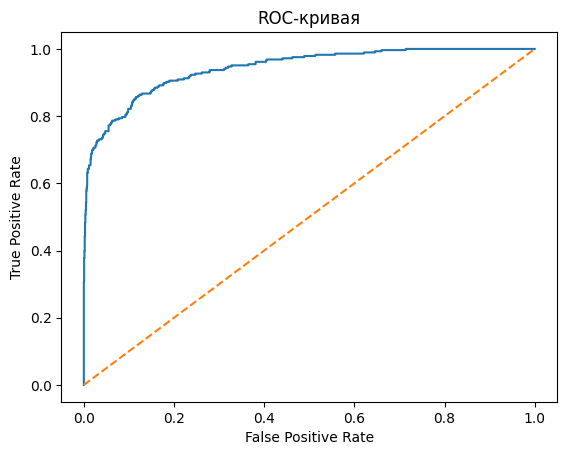

In [53]:
fpr, tpr, thresholds = roc_curve(test_target, probabilities_catboost)

plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

На тестовых данных модель имеет roc-auc = 0.94, что больше ничжнего порога = 0.85 для данной задачи. Для более глубокого понимания работы модели, построим матрицу ошибок, а так же отобразим полный отчет метрик модели

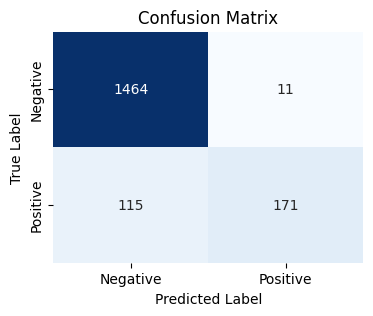

In [54]:
predictions = catboost_model.predict(test_features)

cm = confusion_matrix(test_target, predictions)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(test_target, predictions))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1475
           1       0.94      0.60      0.73       286

    accuracy                           0.93      1761
   macro avg       0.93      0.80      0.84      1761
weighted avg       0.93      0.93      0.92      1761



Модель хорошо разделяет абонентов, которые останутся - в 99% она верно определит таких абонентов.
recall модели для положительного класса равен 0.6, это значит, что из всех ушедших она действительно найдет только 60%.
Это довольно маленькое значение пойманных ушедших клиентов, поскольку наша задача - как можно точнее находить тех, кто прекратит сотрудничество, чтобы точечно приложить усилия для предотвращения ухода клиента. С этим нам немного поможет справиться порог классификации. Попробуем найти наиболее оптимальное значение порога классификации, чтобы увеличить долю пойманных ушедших клиентов.

Посмотрим на значения точности и полноты в зависимости от порога и построим график

In [56]:
for threshold in np.arange(0, 0.52, 0.02):
    predicted_valid = probabilities_catboost > threshold
    precision = precision_score(test_target, predicted_valid)
    recall = recall_score(test_target, predicted_valid)
    print("Порог = {:.2f} | precision = {:.3f}, recall = {:.3f}".format(threshold, precision, recall))

Порог = 0.00 | precision = 0.162, recall = 1.000
Порог = 0.02 | precision = 0.218, recall = 0.997
Порог = 0.04 | precision = 0.277, recall = 0.979
Порог = 0.06 | precision = 0.326, recall = 0.962
Порог = 0.08 | precision = 0.372, recall = 0.937
Порог = 0.10 | precision = 0.432, recall = 0.916
Порог = 0.12 | precision = 0.479, recall = 0.906
Порог = 0.14 | precision = 0.527, recall = 0.878
Порог = 0.16 | precision = 0.580, recall = 0.860
Порог = 0.18 | precision = 0.614, recall = 0.822
Порог = 0.20 | precision = 0.639, recall = 0.797
Порог = 0.22 | precision = 0.688, recall = 0.787
Порог = 0.24 | precision = 0.732, recall = 0.755
Порог = 0.26 | precision = 0.754, recall = 0.752
Порог = 0.28 | precision = 0.784, recall = 0.734
Порог = 0.30 | precision = 0.816, recall = 0.727
Порог = 0.32 | precision = 0.842, recall = 0.710
Порог = 0.34 | precision = 0.870, recall = 0.699
Порог = 0.36 | precision = 0.891, recall = 0.685
Порог = 0.38 | precision = 0.897, recall = 0.668
Порог = 0.40 | preci

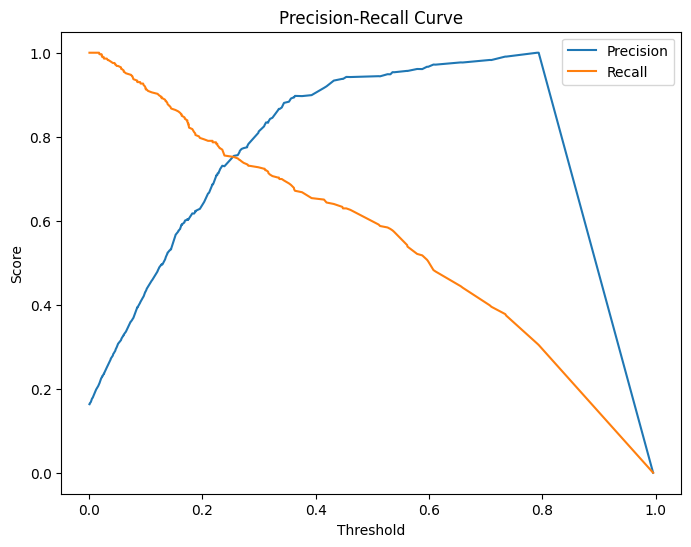

In [57]:
precision_values = []
recall_values = []

for threshold in thresholds:
    predicted_valid = probabilities_catboost > threshold
    precision = precision_score(test_target, predicted_valid)
    recall = recall_score(test_target, predicted_valid)
    precision_values.append(precision)
    recall_values.append(recall)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, recall_values, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [58]:
f1_scores = [f1_score(test_target, probabilities_catboost >= threshold) for threshold in thresholds]
optimal_threshold = thresholds[np.argmax(f1_scores)]

In [59]:
optimal_threshold

0.34390447599103696

Если рассмотреть оптимальный порог по наибольшему значению f1-метрики, то получим оптимальный порог = 0.34.
Тогда recall = 0.70. Т.е мы улавливаем 70 процентов ушедших и 13%-ам оставшихся мы выдаем промокоды и скидки без особой на то причины.
По графику можно выбрать и меньший порог, например 0.2, тогда мы будем ловить 80% ушедших, а неверно выдаем промокоды 37%-ам оставшихся. Остановимся на этом пороге.

Для более качественного выбора порога рекомендуется уточнить условия, которые компания будет предлагать потенциально уходящим клиентам а так же логику расчета, чтобы рассчитать финансовые риски, в зависимости от порога.

Посмотрим на значимость признаков для предсказания модели

In [60]:
column_transformer.fit(train_features)

transformed_train_data = pd.DataFrame(column_transformer.transform(train_features))
transformed_test_data = pd.DataFrame(column_transformer.transform(test_features))

model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, random_state=RANDOM_STATE, verbose=False)
model.fit(transformed_train_data, train_target)

predictions = model.predict(transformed_test_data)

In [61]:
transformed_train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.103405,0.010693,0.001106,0.000114,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
1,0.367077,0.134746,0.049462,0.018156,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
2,-1.095501,1.200123,-1.314736,1.440296,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-0.741511,0.549838,-0.407711,0.302322,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,-0.563787,0.317856,-0.179203,0.101032,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [62]:
transformed_feature_names = column_transformer.get_feature_names_out(input_features=train_features.columns)
transformed_feature_names

array(['num__contract_duration_days', 'num__contract_duration_days^2',
       'num__contract_duration_days^3', 'num__contract_duration_days^4',
       'cat__senior_citizen_1', 'cat__partner_Yes', 'cat__type_One year',
       'cat__type_Two year', 'cat__paper_less_billing_Yes',
       'cat__payment_method_Credit card (automatic)',
       'cat__payment_method_Electronic check',
       'cat__payment_method_Mailed check',
       'cat__internet_service_Fiber optic', 'cat__internet_service_No',
       'cat__online_security_Yes', 'cat__online_backup_Yes',
       'cat__device_protection_Yes', 'cat__tech_support_Yes',
       'cat__streaming_movies_Yes', 'cat__multiple_lines_Yes'],
      dtype=object)

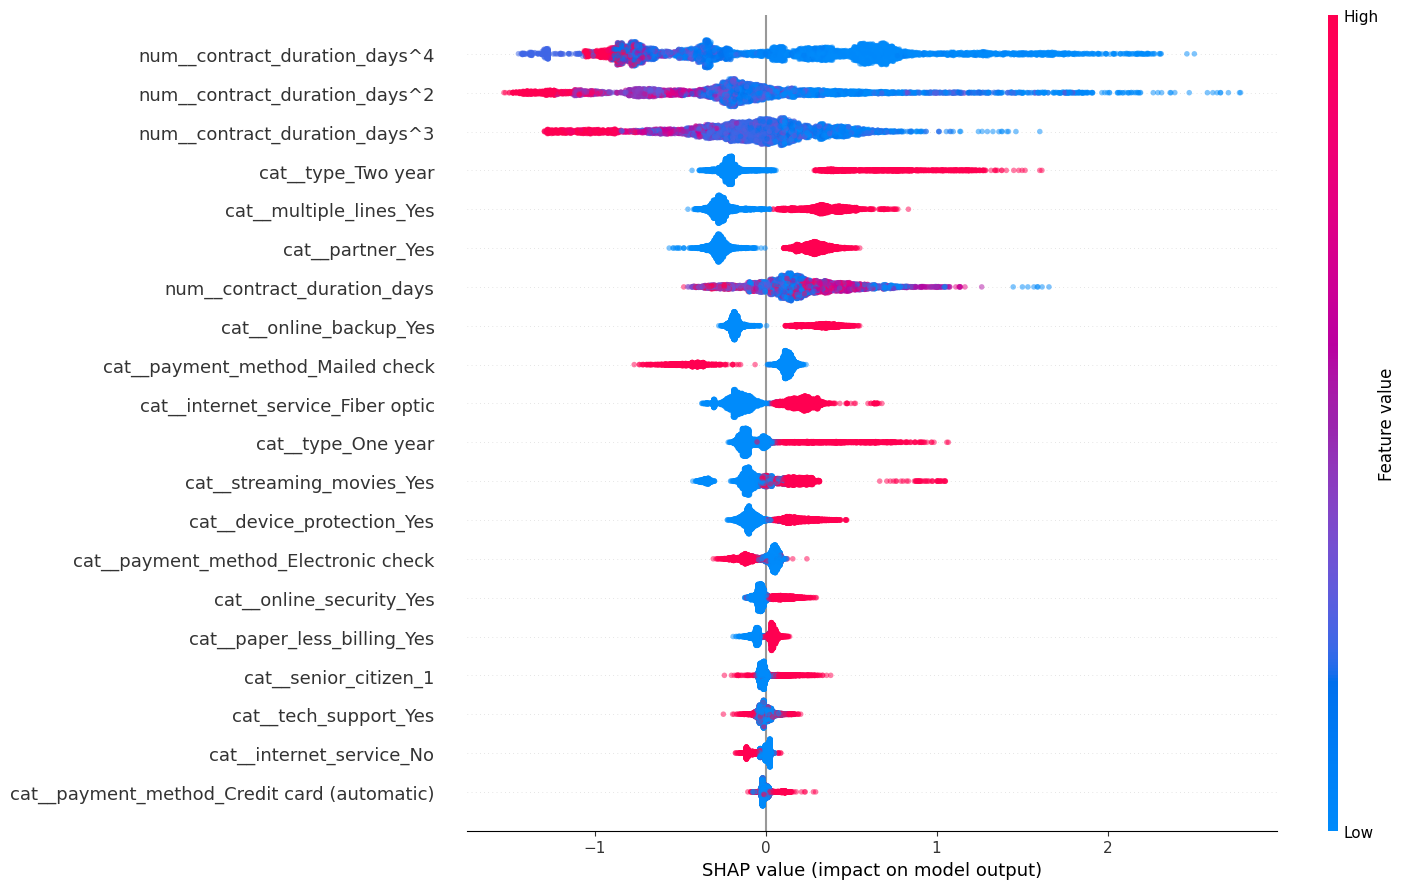

In [63]:
explainer = shap.Explainer(model, feature_names=transformed_feature_names)
shap_values = explainer.shap_values(transformed_train_data)
shap.summary_plot(shap_values, transformed_train_data, feature_names=transformed_feature_names, alpha=0.5, plot_size=(15, 9))

Самыми важным признаками является продолжительность контракта в 4, 3, 2 степени - чем меньше продолжительность контракта, тем выше вероятность, что абонент уйдет. Если тип оплаты контракта 2 года, тем выше вероятность, что человек уйдет. Использует ли человек несколько линий - если да, то вероятность что он уйдет выше, то же самое можно сказать про наличие супруга у абонента.

## Общий вывод и рекомендации заказчику

По плану были выполнены следующие пункты:  

**Проведен исследовательский анализ данных.**   
Данные предоставлены в виде 4-х таблиц без разделения на выборки. После объединения всех таблиц в один датасет, были обнаружены пропуски у тех клиентов, у которых не было данных о подключении онлайн-услуг и дополнительных линий связи. Количество исследуемых объектов - 7043 человека. Данные представлены за период с конца 2013 по 1 февраля 2020 года. Даты подключения и расторжения договора разбиты на месяцы.

С 2014 по 2016 год число подключений уменьшается, далее - растет. Больше всего подключившихся в 2019 году. Чаще всего люди подключаются в фервале, реже всего - в январе. Летом - с мая по август меньше, чем осенью-зимой.
Число ушедших клиентов ежегодно растет. Чаще всего люди прекращают пользоваться договором с сентября по декабрь. Реже - в январе, феврале и апреле.

Средняя продолжительность контракта - 900 дней. Средняя оплата в месяц 70 y.e.

Среди абонентов большая часть - не пожилые. Чуть больше половины абонентов не состоят в браке. Большая часть абонентов выбрали подписку по месяцам, около 1300 человек выбрали оплату за год и около 1500 - за 2 года. Более половины абонентов имеют электронный расчетный лист. Самый популярный метод оплаты - электронный чек (около 35%).

**Произведена предобработка данных**:  
Все пропуски в дополнительных услугах заполнены значением No, что значить что они не подключали эти услуги. Дублитов обнарудено не былло. Аномалий и выбросов нет.

**Подготовлены данные для обучения моделей**:  
Были создан новый признак - продолжительность контракта, которая считалась из даты начала и окончания договора. Выделен целевой признак - если даты окончания договора нет, то целевой признак = 0, если есть = 1 (то есть человек ушел). Соответсвенно даты начала и окончания договора, а также идентификатор пользователя удалены за ненадобностью.
Построили матрицу корреляции и на основании высокой зависимости признаков, удалены следующие признаки: 'gender' - пол, 'monthly_charges' - месяная оплата, 'total_charges' - общие расходы, 'streaming_tv' - услуга телефидения, 'dependents' - наличие детей. Эти данные о клиентах скорее не важны для данной задачи.
Данные были разделены на тренировочную и тестовую в соотношении 75% и 25%.  

**Обучены и подобраны гиперпараметры** для логистической регрессии, и моделей градиентного бустинга: xgboost, catboost, lightgbm.
По метрике roc-auc = 0.92 на тренировочных данных лучшей оказалась модель catboost со следующими гиперпараметрами:
depth=6, iterations = 200, learning_rate’ = 0.1 и степенью полинома = 4. Для данной модели предобработка признаков производилась следующая: категориальные признаки закодированы с помощью onehotecoder, вещественные признаки масштабированы с помощью StandardScaler и добавлены новые признаки в виде полинома количественных признаков с помощью PolynomialFeatures.

Список признаков для обучения лучше модели:  
contract_duration_days  
contract_duration_days^2  
contract_duration_days^3  
contract_duration_days^4  
senior_citizen_1  
partner_Yes  
type_One year  
type_Two year  
paper_less_billing_Yes  
payment_method_Credit card (automatic)  
payment_method_Electronic check  
payment_method_Mailed check  
internet_service_Fiber optic  
internet_service_No  
online_security_Yes  
online_backup_Yes  
device_protection_Yes  
tech_support_Yes  
streaming_movies_Yes  
multiple_lines_Yes  

**Проверка модели**  
Проверена модель на тестовой выборке, метрика roc-auc = 0.94. Метрика recall была = 60%, что означало, что модель не сильно улавливала именно ущедших клиентов. Для поднятия полноты, был изменен порог классификации с 0.5 на 0.2 по максимальному значению f1-меры из всех шагов. Таким образом recall стал = 0.8 и мы сможем улавливать 80% ушедщих, но так же неверно поощрать и стараться удержать 37% и так оставшихся бы.

**Исследовали влияние признаков на предсказания.**  
Самыми важным признаками является продолжительность контракта - чем меньше продолжительность контракта, тем выше вероятность, что абонент уйдет. Если тип оплаты контракта 2 года, тем выше вероятность, что человек уйдет. Использует ли человек несколько линий - если да, то вероятность что он уйдет выше, то же самое можно сказать про наличие супруга у абонента и пользуется ли клиент услугой облачное хранилище файлов для резервного копирования данных.

Таким образом, мы смогли обучить модель для прогноза оттока клиентов.